# Photonic kernels

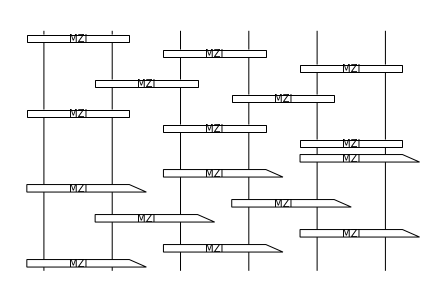

Number of parameters for half chip: 16


In [1]:
from discopy.quantum.optics import ansatz, params_shape
import numpy as np
np.set_printoptions(precision=6)

state = [1, 1, 0, 0, 0, 0]
depth = 3

width = len(state)
n_photons = sum(state)

n_params = np.prod(params_shape(width, depth))
random_datapoint = lambda: np.random.uniform(0, 2, size=(n_params,))

chip = lambda params: ansatz(width, depth, params)

x = random_datapoint()
(chip(x) >> chip(x).dagger()).draw(draw_type_labels=False)
print("Number of parameters for half chip: {}".format(n_params))

In [2]:
from scipy.special import binom
from discopy.quantum.optics import occupation_numbers
np.set_printoptions(suppress=True)

scale = np.array([[binom(m + n - 1, n) for m in range(2, 8)] for n in range(1, 6)])
print(scale)

[[  2.   3.   4.   5.   6.   7.]
 [  3.   6.  10.  15.  21.  28.]
 [  4.  10.  20.  35.  56.  84.]
 [  5.  15.  35.  70. 126. 210.]
 [  6.  21.  56. 126. 252. 462.]]


In [3]:
dim = binom(width + n_photons - 1, n_photons)

print("Dimension of feature space: {}".format(int(dim)))

Dimension of feature space: 21


## Generate random data points

In [4]:
N = 80
X = [random_datapoint() for _ in range(N)]

print("Number of data points: {}".format(N))

Number of data points: 80


In [5]:
# Add datapoints

# a = 12
# N = N + a
# X = X + [random_datapoint() for _ in range(a)]

## Initialise bosonic and distinguishable kernels

In [6]:
def gram_matrix(kernel, x):
    # Build a symmetric positive definite matrix
    N = len(x)
    gram = np.zeros((N, N))
    for i in range(N):
        for j in range(i + 1, N):
            gram[i, j] = kernel(x[i], x[j])
    return gram + np.diag(np.ones(N)) + np.transpose(gram)

In [7]:
import time

q_state = state

# Kernel with indistinguishable photons:

q_kernel = lambda state: lambda x0, x1: (chip(x0) >> chip(x1).dagger()).indist_prob(state, state)
start = time.time()
q_gram = gram_matrix(q_kernel(q_state), X)
print("Time to compute bosonic gram matrix: {}".format(time.time() - start))

Time to compute bosonic gram matrix: 28.297515392303467


In [8]:
# Kernel with distinguishable photons:

c_state = state

c_kernel = lambda state: lambda x0, x1: (chip(x0) >> chip(x1).dagger()).dist_prob(state, state)
start = time.time()
c_gram = gram_matrix(c_kernel(c_state), X)
print("Time to compute distinguishable gram matrix: {}".format(time.time() - start))

Time to compute distinguishable gram matrix: 27.428715229034424


## Generate labels to maximise difference in prediction error bound

In [9]:
from scipy.linalg import inv, eigh

regularization = 0.02

def geometric_diff(k0, k1, reg=0.0):
    S0, P0 = eigh(k0)
    S1, P1 = eigh(k1)
    sqrtk0 = P0.dot(np.diag(np.sqrt(np.absolute(S0)))).dot(np.transpose(P0))
    sqrtk1 = P1.dot(np.diag(np.sqrt(np.absolute(S1)))).dot(np.transpose(P1))
    center = P0.dot(np.diag((S0 + reg) ** -2)).dot(np.transpose(P0))
    matrix = sqrtk1.dot(sqrtk0).dot(center).dot(sqrtk0).dot(sqrtk1)
    S, V = eigh(matrix)
    index = np.argmax(np.absolute(S))
    return np.sqrt(np.absolute(S[index])), sqrtk1.dot(V[:, index])  

g, y = geometric_diff(c_gram, q_gram, reg=regularization)
print("Geometric difference: {} \nEigenvector: y = sqrt(q_gram)v = {}".format(g, y))

Geometric difference: 1.4018616650388025 
Eigenvector: y = sqrt(q_gram)v = [-0.130903  0.102709 -0.720194 ... -0.04421   0.340127 -0.488614]


In [10]:
def model_complexity(k, y, reg=False):
    if not reg:
        return np.transpose(y).dot(inv(k)).dot(y)
    else:
        S, P = eigh(k)
        sqrtk = P.dot(np.diag(np.sqrt(np.absolute(S)))).dot(np.transpose(P))
        matrix = sqrtk.dot(P).dot(np.diag((S + reg) ** -2)).dot(np.transpose(P)).dot(sqrtk)
        return np.transpose(y).dot(matrix).dot(y)

sQ = model_complexity(q_gram, y, reg=False)
sC = model_complexity(c_gram, y, reg=regularization)
assert np.isclose(sC, sQ * g ** 2)
print("s_Q = {} , s_C = {} , g = {}".format(sQ, sC, g))

s_Q = 0.9999999999989537 , s_C = 1.9652161278990203 , g = 1.4018616650388025


In [11]:
y_labels = [1 if z > np.mean(y) else -1 for z in y]
print("Mean of y is {} labels sum to {}.".format(np.mean(y), sum(y_labels)))

Mean of y is -0.03922255732166431 labels sum to 18.


## SVM comparison bosonic vs distinguishable

In [12]:
from sklearn import svm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

test_size = 1 / 3

X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=test_size, random_state=115)

classifier = svm.SVC(kernel='precomputed', verbose=True)

start = time.time()
q_gram_train = gram_matrix(q_kernel(q_state), X_train)
classifier.fit(q_gram_train, y_train)
q_acc_train = accuracy_score(y_train, classifier.predict(q_gram_train))
print("\nTrain accuracy: {}".format(q_acc_train))

q_gram_test = np.array([[q_kernel(q_state)(xi, xj) for xi in X_train] for xj in X_test])
q_acc_test = accuracy_score(y_test, classifier.predict(q_gram_test))
print("\nTest accuracy: {}".format(q_acc_test))
print("\nTime elapsed: {}".format(time.time() - start))

[LibSVM]
Train accuracy: 0.9433962264150944

Test accuracy: 0.8518518518518519

Time elapsed: 41.953596115112305


In [13]:
start = time.time()
c_gram_train = gram_matrix(c_kernel(c_state), X_train)
classifier.fit(c_gram_train, y_train)
c_acc_train = accuracy_score(y_train, classifier.predict(c_gram_train))
print("\nTrain accuracy: {}".format(c_acc_train))

c_gram_test = np.array([[c_kernel(c_state)(xi, xj) for xi in X_train] for xj in X_test])
c_acc_test = accuracy_score(y_test, classifier.predict(c_gram_test))
print("\nTest accuracy: {}".format(c_acc_test))
print("\nTime elapsed: {}".format(time.time() - start))

[LibSVM]
Train accuracy: 0.9056603773584906

Test accuracy: 0.8148148148148148

Time elapsed: 49.22758197784424


In [14]:
# Partially distinguishable photons

# S2 = lambda p: np.array([[1, p], [p, 1]])
# S3 = lambda p: np.array([[1, p, 1], [p, 1, p], [1, p, 1]])

# p_kernel = lambda dist, state: lambda x0, x1: (chip(x0) >> chip(x1).dagger()).pdist_prob(state, state, S=S2(dist))

# for dist in np.arange(0, 1.1, 0.1):
#     gram_train = np.array([[p_kernel(dist, state)(xi, xj) for xi in X_train] for xj in X_train])
#     classifier.fit(gram_train, y_train)
#     gram_test = np.array([[p_kernel(dist, state)(xi, xj) for xi in X_train] for xj in X_test])
#     a_train = accuracy_score(y_train, classifier.predict(gram_train))
#     a_test = accuracy_score(y_test, classifier.predict(gram_test))
#     a = (1 - test_size) * a_train + test_size * a_test
#     print(a_train, a_test, a)

## Comparison with Gaussian kernels

In [15]:
# Compare using geometric difference

from numpy.linalg import norm

reg_param = 0.02

gauss = lambda gamma: lambda x0, x1: np.exp(- gamma * norm(x0 - x1) ** 2)

geos = {}
for gamma in np.logspace(-4, 1, num=100):
    g_gram = np.array([[gauss(gamma)(xi, xj) for xi in X] for xj in X])
    geos.update({gamma : geometric_diff(g_gram, q_gram, reg=reg_param)[0]})
    
gamma_min = min(geos, key=geos.get)

print("Best gamma is {} with geometric difference {}".format(gamma_min, geos[gamma_min]))

Best gamma is 0.4328761281083057 with geometric difference 2.642933441932638


In [16]:
gauss_train = np.array([[gauss(gamma_min)(xi, xj) for xi in X_train] for xj in X_train])
classifier.fit(gauss_train, y_train)
a_gauss_train = accuracy_score(y_train, classifier.predict(gauss_train))
print("\nAccuracy on train: {}".format(a_gauss_train))

gauss_test = np.array([[gauss(gamma_min)(xi, xj) for xi in X_train] for xj in X_test])
a_gauss_test = accuracy_score(y_test, classifier.predict(gauss_test))
print("Accuracy on test: {}".format(a_gauss_test))

[LibSVM]
Accuracy on train: 1.0
Accuracy on test: 0.4074074074074074


In [17]:
# Compare using GridSearch

from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit

C_range = np.logspace(-2, 3, num=50)
gamma_range = np.logspace(-4, 3, num=100)
param_grid = dict(gamma=gamma_range, C=C_range)
grid = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=5, iid=False)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid=False, n_jobs=None,
             param_grid={'C': array([   0.01    ,    0.012649,    0.015999, ...,  625.055193,
        790.604321, 1000.      ]),
                         'gamma': array([   0.0001  ,    0.000118,    0.000138, ...,  722.080902,
        849.753436, 1000.      ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [18]:
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)
a_g_train = accuracy_score(y_train, grid.predict(X_train))
print("Accuracy on train: {}".format(a_gauss_train))
a_g_test = accuracy_score(y_test, grid.predict(X_test))
print("Accuracy on test: {}".format(a_gauss_test))

The best parameters are {'C': 390.6939937054621, 'gamma': 0.008111308307896872} with a score of 0.57
Accuracy on train: 1.0
Accuracy on test: 0.4074074074074074


In [19]:
a_gauss_test = max(a_gauss_test, a_g_test)

print("Best gamma is {}".format(gamma_min))

Best gamma is 0.4328761281083057


## Store results

In [23]:
import pickle 

dump_data = dict()
dump_data.update({'X': X, 'y': y,'g': g, 'regularization': regularization, 'state': state})
dump_data.update({'param_grid_gaussian': param_grid})
filename = "./gdatasets/datasetw{}d{}n{}N{}q{:.2f}c{:.2f}g{:.2f}\
            .pickle".format(width, depth, sum(state), N, q_acc_test, c_acc_test, a_gauss_test)
with open(filename, 'wb') as handle:
    pickle.dump(dump_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Compare with different input states

In [21]:
gram_train = gram_matrix(c_kernel([0, 0, 0, 0, 1, 1]), X_train)
classifier.fit(gram_train, y_train)
a_train = accuracy_score(y_train, classifier.predict(gram_train))
print("\nAccuracy on train: {}".format(a_train))

gram_test = np.array([[c_kernel([0, 0, 0, 0, 1, 1])(xi, xj) for xi in X_train] for xj in X_test])
a_test = accuracy_score(y_test, classifier.predict(gram_test))
print("Accuracy on test: {}".format(a_test))
print("Overall accuracy: {}".format((1 - test_size) * a_train + test_size * a_test))

[LibSVM]
Accuracy on train: 0.7358490566037735
Accuracy on test: 0.4074074074074074
Overall accuracy: 0.6263685068716516


In [22]:
q2_gram_train = gram_matrix(q_kernel([1, 1, 1, 0, 0, 0]), X_train)
classifier.fit(q2_gram_train, y_train)
a_train = accuracy_score(y_train, classifier.predict(q2_gram_train))
print("\nAccuracy on train: {}".format(a_train))

q2_gram_test = np.array([[q_kernel([1, 1, 1, 0, 0, 0])(xi, xj) for xi in X_train] for xj in X_test])
a_test = accuracy_score(y_test, classifier.predict(q2_gram_test))
print("Accuracy on test: {}".format(a_test))
print("Overall accuracy: {}".format((1 - test_size) * a_train + test_size * a_test))

[LibSVM]
Accuracy on train: 1.0
Accuracy on test: 0.7777777777777778
Overall accuracy: 0.925925925925926
